In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os

os.chdir("/content/drive/MyDrive/Colab Notebooks/gi-disease-detection")

# Loading and Cleaning the Dataset

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

In [4]:
SOURCE = "local"
BATCH_SIZE = 32
RAW_DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/gi-disease-detection/raw_data"
IMAGE_RESCALE_RATIO = 1. / 255
IMAGE_TARGET_WIDTH = 224
IMAGE_TARGET_HEIGHT = 224

In [74]:
def train_val_test_dataset_generator(source = "local"):
    """
    Generate the train, validation, and test batches.
    """
    def load_images(path):
        """
        Enter a path to load images from.
        """
        datagen = ImageDataGenerator(rescale = IMAGE_RESCALE_RATIO)
        images = datagen.flow_from_directory(path,
                                             target_size = (IMAGE_TARGET_WIDTH, IMAGE_TARGET_HEIGHT),
                                             color_mode = "rgb",
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

        return images

    if source == "local":
        train_directory = os.path.join(RAW_DATA_PATH, "train")
        val_directory = os.path.join(RAW_DATA_PATH, "val")
        test_directory = os.path.join(RAW_DATA_PATH, "test")

    #this doesn't work right now
    if source == "cloud":
        credentials = service_account.Credentials.from_service_account_file(GOOGLE_APPLICATION_CREDENTIALS)
        client = storage.Client(project = GCLOUD_PROJECT_ID, credentials = credentials)
        bucket = client.get_bucket(BUCKET_NAME)

        train_directory = f"gs://{BUCKET_NAME}/train"
        val_directory = f"gs://{BUCKET_NAME}/val"
        test_directory = f"gs://{BUCKET_NAME}/test"

    train_dataset = load_images(train_directory)
    val_dataset = load_images(val_directory)
    test_dataset = load_images(test_directory)

    return train_dataset, val_dataset, test_dataset

In [75]:
train_dataset, val_dataset, test_dataset = train_val_test_dataset_generator(source = SOURCE)

Found 2400 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [31]:
def convert_to_numpy(dataset):
    """
    Converts DirectoryIterator dataset to numpy.array before cleaning images.
    """
    X = np.concatenate([dataset.next()[0] for i in range(dataset.__len__())])
    y = np.concatenate([dataset.next()[1] for i in range(dataset.__len__())])

    return X, y

In [ ]:
# X_train, y_train = convert_to_numpy(train_dataset)

In [ ]:
# X_val, y_val = convert_to_numpy(val_dataset)

In [76]:
X_test, y_test = convert_to_numpy(test_dataset)

# First Baseline Model

In [16]:
from tensorflow.keras import optimizers, Model, Sequential, layers, metrics
from tensorflow.keras.callbacks import EarlyStopping

In [77]:
es = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
recall = metrics.Recall()
optimizer = optimizers.Adam(learning_rate = 0.001)

In [78]:
model = Sequential()

model.add(layers.Conv2D(64, kernel_size=(3,3), input_shape = (224, 224, 3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(3,3)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(32, kernel_size=(2,2), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(16, kernel_size=(2,2), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(5, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))

In [79]:
model.compile(loss='categorical_crossentropy',
            optimizer=optimizer,
            metrics=[recall, 'accuracy'])

In [80]:
history = model.fit(train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[es],
    verbose=1)

Epoch 1/100
75/75 [==============================] - 36s 461ms/step - loss: 0.8546 - recall_3: 0.2679 - accuracy: 0.5058 - val_loss: 0.7309 - val_recall_3: 0.4933 - val_accuracy: 0.6507
Epoch 2/100
75/75 [==============================] - 34s 458ms/step - loss: 0.5456 - recall_3: 0.5721 - accuracy: 0.7246 - val_loss: 0.6290 - val_recall_3: 0.6187 - val_accuracy: 0.6520
Epoch 3/100
75/75 [==============================] - 34s 460ms/step - loss: 0.4056 - recall_3: 0.7387 - accuracy: 0.8383 - val_loss: 0.9265 - val_recall_3: 0.5947 - val_accuracy: 0.6340
Epoch 4/100
75/75 [==============================] - 34s 460ms/step - loss: 0.3335 - recall_3: 0.7887 - accuracy: 0.8737 - val_loss: 0.6390 - val_recall_3: 0.6833 - val_accuracy: 0.6873
Epoch 5/100
75/75 [==============================] - 34s 459ms/step - loss: 0.2790 - recall_3: 0.8138 - accuracy: 0.9083 - val_loss: 0.7312 - val_recall_3: 0.6667 - val_accuracy: 0.6840
Epoch 6/100
75/75 [==============================] - 35s 463ms/step - 

In [81]:
model.evaluate(test_dataset)

19/19 [==============================] - 6s 298ms/step - loss: 0.5810 - recall_3: 0.6333 - accuracy: 0.6600


[0.5809885263442993, 0.6333333253860474, 0.6600000262260437]

In [82]:
y_pred = model.predict(X_test)

19/19 [==============================] - 0s 7ms/step


In [83]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [84]:
y_pred_updated = np.argmax(y_pred, axis=1)
y_test_updated = np.argmax(y_test, axis=1)

In [85]:
cm = confusion_matrix(y_test_updated, y_pred_updated, normalize = "true")

In [86]:
classes = ["normal", "UC", "polyps"]

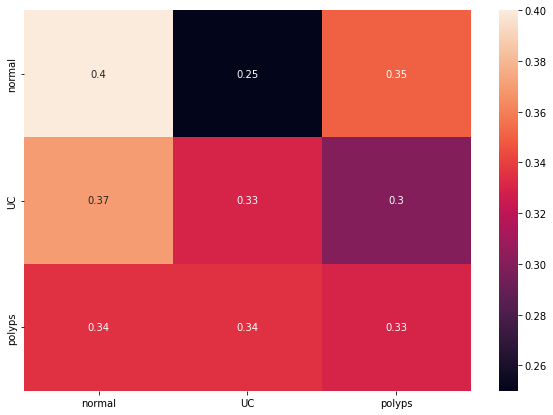

In [88]:
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (10, 7))
cm_plot = sns.heatmap(df_cm, annot = True);

In [89]:
cm_plot.figure.savefig("cm_baseline.png")